In [297]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

In [298]:
import configparser

# Initialize the parser
config = configparser.ConfigParser()

# Read the config file
config.read('config.ini')

ACCELERATION_SMOOTHING = config['processing'].getfloat('acceleration_smoothing')
BAROMETER_SMOOTHING = config['processing'].getfloat('barometer_smoothing')
LOWER_ACC_THRESHOLD = config['processing'].getfloat('lower_acc_threshold')
UPPER_ACC_THRESHOLD = config['processing'].getfloat('upper_acc_threshold')
C_LIM = config['processing'].getint('c_lim')

In [299]:
def translate_step(df, col):
    previous_step = None
    current_step = df[col].iloc[len(df) - 1]
    for i in range(len(df) - 1, -1, -1):
        if df[col].iloc[i] != current_step:
            previous_step = current_step
            current_step = df[col].iloc[i]
        df.at[i, col] = previous_step

def translate_forward(df, col, steps):
    for i in range(len(df) - steps):
        df.at[i, col] = df[col].iloc[i + steps]
    
    for i in range(len(df) - steps, len(df)):
        df.at[i, col] = 0

In [300]:
def interpolate_transitions(df, col):
    values = df[col].values
    new_values = []

    i = 0
    while i < len(values):
        start_val = values[i]
        j = i
        
        while j < len(values) and values[j] == start_val:
            j += 1
        
        if j < len(values):
            end_val = values[j]
            num_steps = j - i
            interpolated_values = np.linspace(start_val, end_val, num_steps + 1)[:-1]
            new_values.extend(interpolated_values)
        else:
            new_values.extend(values[i:])
            break
        
        i = j
    
    df[col] = new_values

In [301]:
def load_mtn(path):
    df = pd.read_csv(path)
    # translate_step(df, 'pressure')
    if 'pressure' in df.columns:
        translate_forward(df, 'pressure', 190)

        df = df[df['pressure'] != 0.0]
        df = df.reset_index(drop=True)

    df[['acc_x', 'acc_y', 'acc_z']] = df[['acc_x', 'acc_y', 'acc_z']] * 9.81

    if df['timestamps'].iloc[0] > 10000:
        df['timestamps'] = (df['timestamps'] - df['timestamps'].iloc[0]) / 1000
    
    df['aAcc'] = np.sqrt(df['acc_x'] ** 2 + df['acc_y'] ** 2 + df['acc_z'] ** 2)

    return df

We will only work with the df['acc'] column as this will allow us to change it to just acc_z in the future if need be

In [302]:
def save_df(df, path):
    df.to_csv(path, index=False)

In [303]:
def initial_pressure_corrections(df):
    df['pressure'] = df['pressure'] - df['pressure'].iloc[0]


In [304]:
# Max Temp Change (Burj Khalifa) = 7.5 degrees celcius
def get_pressure_height(df):
    T0 = 288.15  # Standard temperature at sea level in Kelvin
    L = 0.0065   # Temperature lapse rate in K/m
    P0 = 101325  # Standard atmospheric pressure at sea level in Pascals
    R = 8.314    # Universal gas constant in J/(mol·K)
    g = 9.80665  # Acceleration due to gravity in m/s²
    # M = 0.0289644  # Molar mass of dry air in kg/mol
    humidity = 0.25
    M = humidity * 0.0180 + (1 - humidity) * 0.0289644

    assert 'pressure' in df.columns, "DataFrame must contain a 'pressure' column."
    
    df['pHeight'] = 0.0

    # Calculate height from pressure using the barometric formula
    for i in range(len(df)):
        P = df['pressure'].iloc[i] * 100  # Pressure in Pascals
        if P <= 0:
            raise ValueError("Pressure must be positive.")
        
        height = (T0 / L) * (1 - (P / P0)**(R * L / (g * M)))
        df.at[i, 'pHeight'] = height

    df["pHeight"] = df["pHeight"] - df["pHeight"].iloc[0];


In [305]:
def drift_correction(df, bound):
    rolling_sum = 0
    num_of_pnts = 0
    for acc in df['aAcc']:
        if acc == df['aAcc'].iloc[0] or abs(rolling_sum / num_of_pnts - acc) < bound:
            rolling_sum += acc
            num_of_pnts += 1
    df['aAcc'] -= rolling_sum / num_of_pnts


In [306]:
def smooth(df, col, SMOOTHING):

    smoothed_values = []
    prev = None
    for row in df[col]:

        if prev is None:
            smoothed_value = row
        else:
            smoothed_value = (prev + SMOOTHING * row) / (1 + SMOOTHING)
        
        prev = smoothed_value
        smoothed_values.append(smoothed_value)

    df[col] = smoothed_values


In [307]:
def correct_vel_at_stationary(df, col, effect):
    assert "aStages" in df.columns, "aStages needs to be in the dataframe"
    assert col in df.columns, f"{col} needs to be in the dataframe"
    for i in range(len(df)):
        if df['aStages'].iloc[i] == 0:
            if df[col].iloc[i] > effect:
                df.loc[i:, [col]] = df.loc[i:, [col]] - effect
            elif df[col].iloc[i] < - effect:
                df.loc[i:, [col]] = df.loc[i:, [col]] + effect
            else:
                df.at[i, col] = 0

In [308]:
def differentiate(df, u, v, new_name):
    assert u in df.columns, f"DataFrame must include {u}"
    assert v in df.columns, f"DataFrame must include {v}"
    df[new_name] = 0.0

    for i in range(1, len(df)):
        du = df[u].iloc[i] - df[u].iloc[i - 1]
        dv = df[v].iloc[i] - df[v].iloc[i - 1]

        if dv != 0:
            df.at[i, new_name] = du / dv

In [309]:
def integrate(df, u, v, new_name):
    assert u in df.columns, f"DataFrame must include {u}"
    assert v in df.columns, f"DataFrame must include {v}"
    df[new_name] = 0.0

    for i in range(1, len(df)):
        avg_u = (df[u].iloc[i] + df[u].iloc[i - 1]) / 2
        dv = df[v].iloc[i] - df[v].iloc[i - 1]
        
        df.at[i, new_name] = df[new_name].iloc[i - 1] + avg_u * dv

In [310]:
def add_stages(df, LB, UB, col, prefix):
    max_acc = max(df[col])
    new_col = prefix + "Stages"
    a_lt = LB * max_acc
    a_ut = UB * max_acc

    df[new_col] = 0
    C = 0
    Clim = 20
    for i in range(len(df)):
        acc = df[col].iloc[i]
        curr_stage = df[new_col].iloc[i]

        if abs(acc) > a_ut: C += 1
        else: C = 0

        if abs(acc) < a_lt:
            if curr_stage == 1:
                df.loc[i:, [new_col]] = 2
            elif curr_stage == 3:
                df.loc[i:, [new_col]] = 0
        
        if C >= Clim and curr_stage in [0, 2]:
            j = i
            while abs(df[col].iloc[j]) > a_lt:
                j -= 1
            df.loc[j:, [new_col]] = df[new_col].iloc[i] + 1


In [311]:
def linear_offset(df, label, offset, start, stop):
    dt = df['timestamps'].iloc[stop] - df['timestamps'].iloc[start]
    for i in range(start, stop):
        df.at[i, label] = df[label].iloc[i] - offset * ((df['timestamps'].iloc[i] - df['timestamps'].iloc[start]) / dt)

In [312]:
def single_correct_height_and_get_floors(df, height_label):
    assert 'aStages' in df.columns, "aStages needs to be in the dataframe"
    assert height_label in df.columns, f"{height_label} needs to be in the dataframe"
    floors = [0]

    i = 0
    while i < len(df):
        height_data = []
        while i < len(df) and (not len(height_data) or df['aStages'].iloc[i] == 0):
            if df['aStages'].iloc[i] == 0:
                height_data.append(df[height_label].iloc[i])
            i += 1

        if (len(height_data) <= 4): continue

        np_floors = np.array(floors)
        height_data = np.array(height_data)
        height_data = height_data[int(len(height_data) * 0.25):int(len(height_data) * 0.75)]
        height = np.mean(height_data)
        floor_height_differences = np_floors - height
        abs_min_floor_height_dif = np.min(np.abs(floor_height_differences))

        if abs_min_floor_height_dif < 1.2:
            abs_min_index = np.argmin(np.abs(floor_height_differences) - abs_min_floor_height_dif)
            df.loc[i - len(height_data):, [height_label]] = df.loc[i - len(height_data):, [height_label]] + floor_height_differences[abs_min_index]
        else:
            floors.append(float(height))
        
    return floors
        

In [313]:
def proporionate_correct_and_get_floors(df, height1_label, height2_label):
    assert 'aStages' in df.columns, "aStages needs to be in the dataframe"
    assert height1_label in df.columns, f"{height1_label} needs to be in the dataframe"
    assert height2_label in df.columns, f"{height2_label} needs to be in the dataframe"
    floors = [0]

    i = 0
    while i < len(df):
        height1_data = []
        height2_data = []
        while i < len(df) and (not len(height1_data) or df['aStages'].iloc[i] == 0):
            if df['aStages'].iloc[i] == 0:
                height1_data.append(df[height1_label].iloc[i])
                height2_data.append(df[height2_label].iloc[i])
            i += 1

        if (len(height1_data) <= 4 or len(height2_data) <= 4): continue

        height1_data = height1_data[int(len(height1_data) * 0.25):int(len(height1_data) * 0.75)]
        height2_data = height2_data[int(len(height2_data) * 0.25):int(len(height2_data) * 0.75)]

        np_floors = np.array(floors)

        # Determine whether or not it is a new floor
        height_data = (np.array(height1_data) * 0.8 + np.array(height2_data) * 0.2) # True height estimate
        height = np.mean(height_data)

        floor_height_differences = np_floors - height
        abs_min_floor_height_dif = np.min(np.abs(floor_height_differences))

        if abs_min_floor_height_dif > 1.2:

            floors.append(float(height))
            
            np_floors = np.array(floors)
            floor_height_differences = np_floors - height
            abs_min_floor_height_dif = np.min(np.abs(floor_height_differences))

        floor_index = np.argmin(np.abs(floor_height_differences - height))
        # Move height1 to match with true height
        floor_height1_differences = np_floors - np.mean(height1_data)
        offset1 = floor_height1_differences[floor_index]
        df.loc[i - len(height1_data):, [height1_label]] = df.loc[i - len(height1_data):, [height1_label]] + offset1

        #Move height2 to match with true height
        floor_height2_differences = np_floors - np.mean(height2_data)
        offset2 = floor_height2_differences[floor_index]
        df.loc[i - len(height2_data):, [height2_label]] = df.loc[i - len(height2_data):, [height2_label]] + offset2
        
    return floors

In [314]:
def dependant_correction_and_get_floors(df, height1_label, height2_label):
    assert 'aStages' in df.columns, "aStages needs to be in the dataframe"
    assert height1_label in df.columns, f"{height1_label} needs to be in the dataframe"
    assert height2_label in df.columns, f"{height2_label} needs to be in the dataframe"
    floors = [0]
    dependant_floors = [0]

    i = 0
    previous_stationary_point = 0
    while i < len(df):
        height1_data = []
        height2_data = []
        while i < len(df) and (not len(height1_data) or df['aStages'].iloc[i] == 0):
            if df['aStages'].iloc[i] == 0:
                height1_data.append(df[height1_label].iloc[i])
                height2_data.append(df[height2_label].iloc[i])
            i += 1

        if (len(height1_data) <= 4 or len(height2_data) <= 4): continue

        height1_data = height1_data[int(len(height1_data) * 0.25):int(len(height1_data) * 0.75)]
        height2_data = height2_data[int(len(height2_data) * 0.25):int(len(height2_data) * 0.75)]

        np_floors = np.array(floors)
        height = np.mean(height1_data)

        floor_height_differences = np_floors - height
        abs_min_floor_height_dif = np.min(np.abs(floor_height_differences))

        if abs_min_floor_height_dif > 1.2:

            floors.append(float(height))
            dependant_floors.append(float(np.mean(height2_data)))
            
            np_floors = np.array(floors)
            floor_height_differences = np_floors - height
            abs_min_floor_height_dif = np.min(np.abs(floor_height_differences))
        
        floor_index = np.argmin(np.abs(floor_height_differences - height))
        start_stationary_index = i - 2 * len(height1_data)
        # Move height1 to match with floor height
        floor_height1_differences = np_floors - np.mean(height1_data)
        offset1 = floor_height1_differences[floor_index]
        df.loc[start_stationary_index:, [height1_label]] = df.loc[start_stationary_index:, [height1_label]] + offset1
        linear_offset(df, height1_label, - offset1, previous_stationary_point, start_stationary_index)

        #Move height2 to match with floor height
        floor_height2_differences = np.array(dependant_floors) - np.mean(height2_data)
        offset2 = floor_height2_differences[floor_index]
        df.loc[start_stationary_index:, [height2_label]] = df.loc[start_stationary_index:, [height2_label]] + offset2
        linear_offset(df, height2_label, - offset2, previous_stationary_point, start_stationary_index)

        previous_stationary_point = i

    return (floors, dependant_floors)
        


In [315]:

directory = "./mtn"
for f in os.listdir(directory):
    df = load_mtn(os.path.join(directory, f))
    smooth(df, 'aAcc', ACCELERATION_SMOOTHING)
    drift_correction(df, bound=0.02)
    add_stages(df, LOWER_ACC_THRESHOLD, UPPER_ACC_THRESHOLD, 'aAcc', 'a')
    differentiate(df, 'aAcc', 'timestamps', 'aJerk')
    integrate(df, 'aAcc', 'timestamps', 'aVelocity')
    add_stages(df, 0.2, 0.6, 'aVelocity', 'av')
    correct_vel_at_stationary(df, 'aVelocity', 0.0005)
    integrate(df, 'aVelocity', 'timestamps', 'aHeight')


    if 'pressure' in df.columns:
        interpolate_transitions(df, 'pressure')
        get_pressure_height(df)

        pFloors, aFloors = dependant_correction_and_get_floors(df, 'pHeight', 'aHeight')

        differentiate(df, 'pHeight', 'timestamps', 'pVelocity')

        differentiate(df, 'pVelocity', 'timestamps', 'pAcc')
        differentiate(df, 'pAcc', 'timestamps', 'pJerk')

    if (df['aStages'] == 2).sum() > 200:
        save_dir = "results-a"
    else:
        save_dir = "results-b"
        
    save_df(df, f"./{save_dir}/" + str(hash(os.path.join(directory, f))))


In [316]:
def chart(col1, col2=None):
    fig, ax1 = plt.subplots()

    labels = {
        'aAcc': 'Acceleration (m/s^2)',
        'aJerk': 'Jerk (m/s^3)',
        'aHeight': 'Height (m)',
        'aVelocity': 'Velocity (m/s)'
    }
    col1_label = labels[col1]

    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel(col1_label, color='tab:blue')
    ax1.plot(df['timestamps'], df[col1], color='tab:blue', label=col1)
    ax1.tick_params(axis='y', labelcolor='tab:blue')   
    plt.axhline(y=0, color='r', linestyle='--', label='y=0')

    if col2 != None:
        ax2 = ax1.twinx()
        ax2.set_ylabel(col2, color='tab:red')
        ax2.plot(df['timestamps'], df[col2], color='tab:red', label=col2)
        ax2.tick_params(axis='y', labelcolor='tab:red')

        minimum = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
        maximum = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
        ax1.set_ylim(minimum, maximum)
        ax2.set_ylim(minimum, maximum)

        plt.title(f'{col1_label} and {col2} vs. Time')
    
    else:
        plt.title(f'{col1_label} vs. Time') 

    fig.tight_layout()
    plt.show()

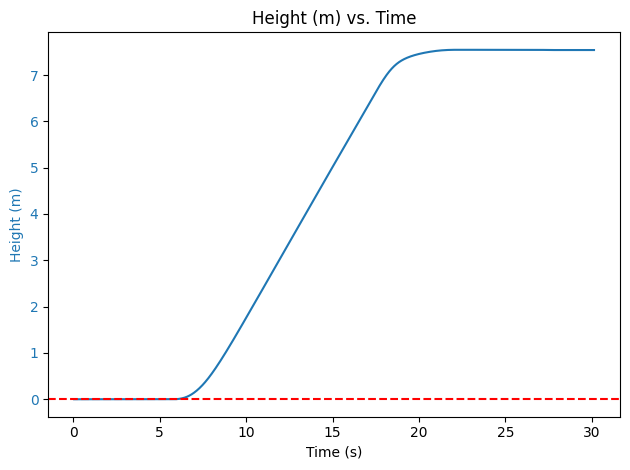

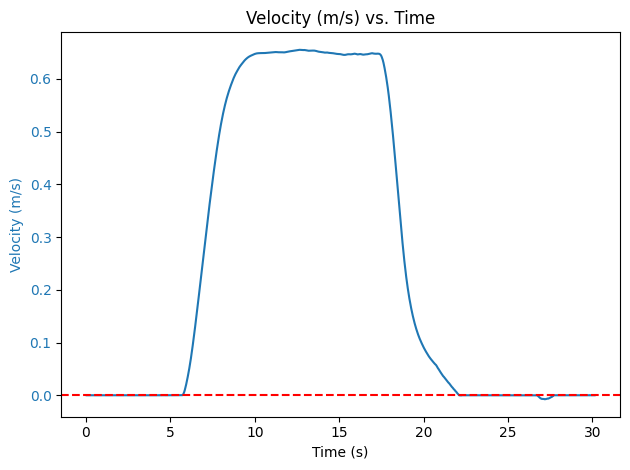

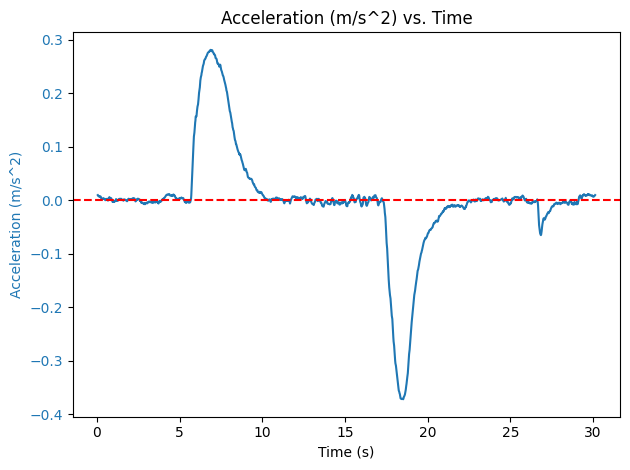

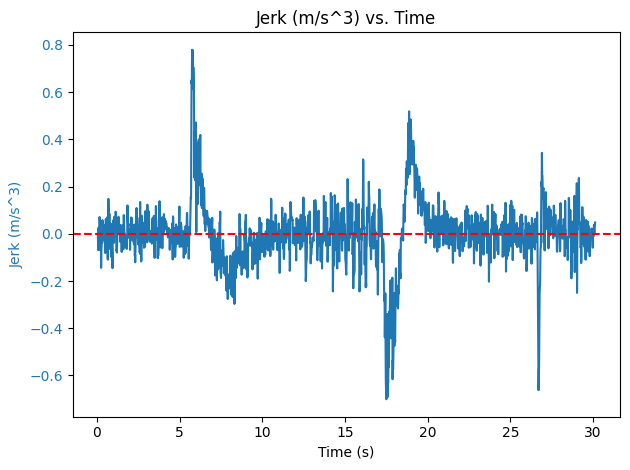

In [317]:
chart('aHeight', 'pHeight' if 'pHeight' in df.columns else None)
# chart('aStages', 'pHeight' if 'pHeight' in df.columns else None)
chart('aVelocity')
chart('aAcc')
chart('aJerk')